# **ABC for alpha-stable models**

⚠️ Required for this project ⚠️
```bash
pip install scipy scikit-optimize
pip install tabulate
```

This project is based on the following paper: https://doi.org/10.1016/j.csda.2010.10.004 which proposes an ABC approach to estimate the parameters of the following type of model : $ X_1, . . . , X_n $ are IID and follow an alpha-stable distribution, see Section 3.1 of the paper for the definition of this type of distribution. Alpha-distributions are stable through addition. Two prominent examples are the Cauchy and the Gaussian. Outside of these two cases, the probability density of such a distribution is not tractable (which is why it makes sense to use ABC). Also, alpha-stable distributions are generally heavy-tailed (except the Gaussian distribution).

1. Implement the generator for alpha-stable distributions proposed in Appendix B.

2. Explain how you could modify this generator to use RQMC sequences in order to approximate expectations under an alpha-stable distribution. Implement this for a certain function, and compare the resulting RQMC estimates with standard Monte Carlo estimates. (Careful: again, an alpha-stable distribution is typically heavy-tailed, make sure you choose a function whose variance is finite. . . ).

3. Implement and compare different ABC algorithms to sample from the ABC posterior (2.2). (You may simulate the data from the model, using sensible parameter values.) In each case, use the same summary statistic (choose one of the statistics proposed in the paper). You may start with **ABC-reject** (presented in the course), and then consider **MCMC-ABC** (see Marjoram et al, 2003, Markov chain Monte Carlo without likelihoods), and the **SMC-AB**C** algorithm proposed in the paper. Think carefully about what it means for a given algorithm to “work better” than another one in this context, especially regarding the choice of $ \varepsilon $, etc.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import Image
from scipy.stats import levy_stable
from scipy.interpolate import RegularGridInterpolator
from scipy.stats import multivariate_normal
from scipy.stats import qmc
from scipy.spatial.distance import euclidean
from scipy.stats import norm,  uniform
from sklearn.utils import check_random_state
from scipy.stats.qmc import Sobol, Halton

## **I. Question 1 : Implementation of the alpha-stable distribution**

In [2]:
def generate(n_value, alpha, beta, gamma, delta):
    """
    Generates alpha-stable samples S(alpha, beta, gamma, delta) using the Chambers-Mallows-Stuck method.

    Parameters :
    - n_value (int) : number of values to generate
    - alpha (float) ∈ (0, 2]
    - beta (float) ∈ [-1, 1]
    - gamma (float) > 0
    - delta (float
    """
    if not (0 < alpha <= 2):
        raise ValueError("alpha must be in the range (0, 2]")
    if not (-1 <= beta <= 1):
        raise ValueError("beta must be in range [-1, 1]")
    if gamma <= 0:
        raise ValueError("gamma must be strictly positive")

    u = np.random.uniform(-np.pi/2, np.pi/2, n_value)
    w = np.random.exponential(scale=1, size=n_value)

    def S_alpha_beta(alpha, beta):
        return (1 + (beta * np.tan(np.pi * alpha / 2))**2)**(1 / (2 * alpha))

    def B_alpha_beta(alpha, beta):
        return (1 / alpha) * np.arctan(beta * np.tan(np.pi * alpha / 2))

    if alpha != 1:
        S = S_alpha_beta(alpha, beta)
        B = B_alpha_beta(alpha, beta)
        y = S * (np.sin(alpha * (u + B)) / (np.cos(u))**(1 / alpha)) * \
            (np.cos(u - alpha * (u + B)) / w)**((1 - alpha) / alpha)
    else:
        y = (2 / np.pi) * ((np.pi / 2 + beta * u) * np.tan(u) -
                           beta * np.log((np.pi / 2 * w * np.cos(u)) / (np.pi / 2 + beta * u)))

    return gamma * y + delta

In [3]:
print(generate(10, 1.9, 0.8, 4, 9))

[ 5.86539759  8.2327215  10.47856289  4.68673903  3.05934169  2.48663672
 17.59139697 18.32520771 10.46460895 14.08355044]


MovieWriter imagemagick unavailable; using Pillow instead.


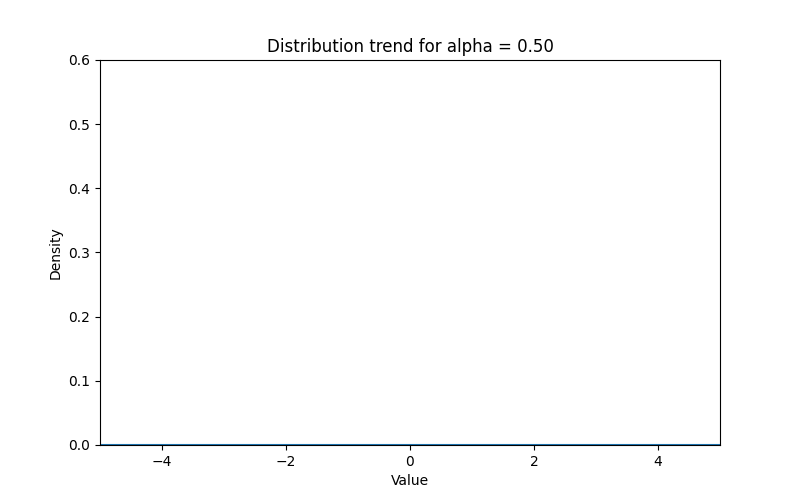

In [4]:
# Parameter
beta = 0
gamma = 1
delta = 0
n_values = 5000
alpha_values = np.linspace(0.5, 2, 30)  # Continuous evolution of alpha

fig, ax = plt.subplots(figsize=(8, 5))

def update(frame):
    ax.clear()
    alpha = alpha_values[frame]
    samples = generate(n_values, alpha, beta, gamma, delta)
    sns.kdeplot(samples, ax=ax, bw_adjust=1.5)
    ax.set_xlim(-5, 5)
    ax.set_ylim(0, 0.6)
    ax.set_title(f"Distribution trend for alpha = {alpha:.2f}")
    ax.set_xlabel("Value")
    ax.set_ylabel("Density")

# Animation creation
anim = animation.FuncAnimation(fig, update, frames=len(alpha_values), repeat=True)

# Record animation
anim.save("evolution_alpha.gif", writer="imagemagick", fps=5)
plt.close(fig)

# To display the animation next
from IPython.display import Image
Image(filename="evolution_alpha.gif")

## **II. Question 2 : Optimize this generator**

We will conduct different optimisations in this part :
- II. 1. RQMC
- II. 2. Antithetic variates

### **II. 1. RQMC**

We analyse 2 sequences :
- Sobol
- Halton

To approximate expectations under an alpha-stable distribution using RQMC, we modify the Chambers-Mallows-Stuck (CMS) generator by replacing the two random inputs with points from a low-discrepancy sequence.

We generate points $ (u_1, u_2) ∈ [0,1]^2 $ using a randomized quasi-Monte Carlo sequence (e.g., Sobol or Halton), and transform them as follows:

- $U = -\pi/2 + \pi \cdot u_1$, so that $U \sim \text{Uniform}[-\pi/2, \pi/2]$
- $W = -\log(u_2)$, so that $W \sim \text{Exp}(1)$

These values are then passed to the CMS transformation to generate samples from the $ S(α,β,γ,δ) $

We use the RQMC samples to evaluate the expectation $ E[f(X)] $, and compare the result to the standard Monte Carlo estimate.

*Note*: the test function $ f $ must have finite variance due to the heavy tails of alpha-stable distributions.

#### **II. 1. a. Understanding theses sequences**

We can even improve these sequences by randomizing them.

/usr/local/lib/python3.12/site-packages/scipy/stats/_qmc.py:993: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


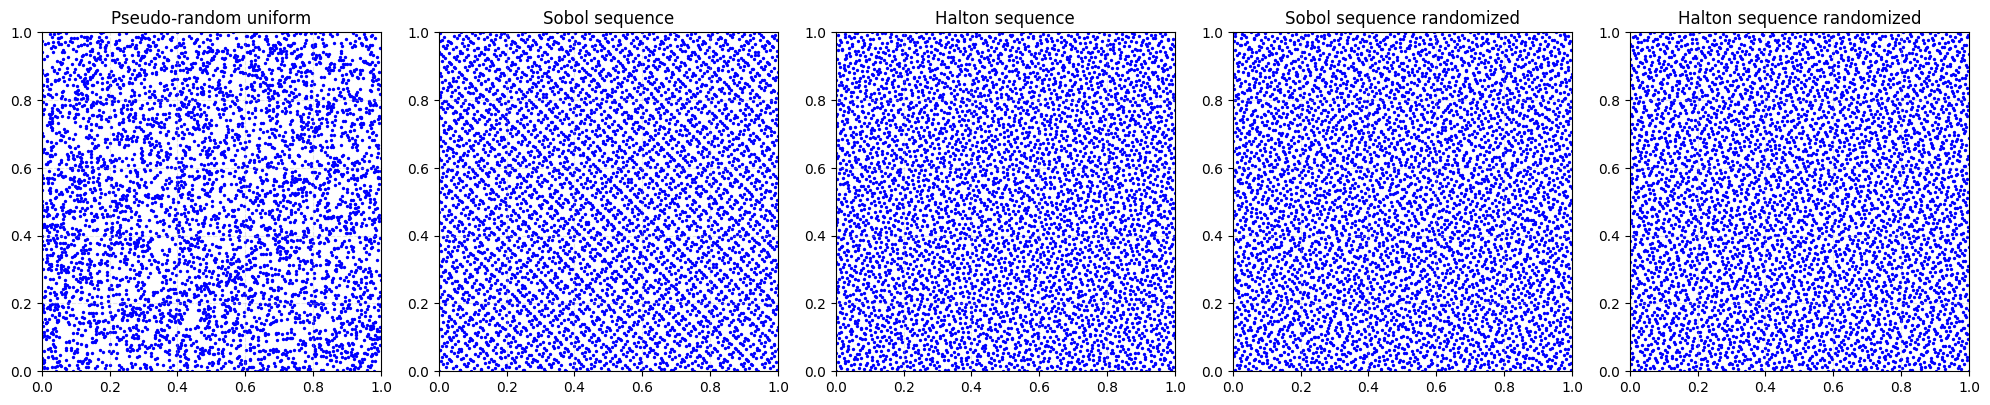

In [5]:
# Number of points
n_points = 5000

# Uniform
rng = check_random_state(0)
uniform_points = rng.rand(n_points, 2)

# Sobol sequence
sobol_engine = Sobol(d=2, scramble=False)
sobol_points = sobol_engine.random(n=n_points)

sobol_engine_randomized = Sobol(d=2, scramble=True, seed=rng)
sobol_points_randomized = sobol_engine_randomized.random(n=n_points)


# Halton sequence
halton_engine = Halton(d=2, scramble=False)
halton_points = halton_engine.random(n=n_points)

halton_engine_randomized = Halton(d=2, scramble=True, seed=rng)
halton_points_randomized = halton_engine_randomized.random(n=n_points)


fig, axs = plt.subplots(1, 5, figsize=(20, 4))
titles = ["Pseudo-random uniform", "Sobol sequence", "Halton sequence", "Sobol sequence randomized", "Halton sequence randomized"]
data = [uniform_points, sobol_points, halton_points, sobol_points_randomized, halton_points_randomized]

for ax, points, title in zip(axs, data, titles):
    ax.scatter(points[:, 0], points[:, 1], s=2, color='blue')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_title(title)
    ax.set_aspect('equal')
    ax.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

The figure compares different 2D point generation methods within the unit square $ [0,1]^2 $ : pseudo-random uniform sampling, deterministic low-discrepancy sequences (Sobol and Halton), and their randomized versions used in randomized quasi-Monte Carlo (RQMC).

- Uniform sampling exhibits irregularity and clustering, which can lead to slow convergence in Monte Carlo integration.

- Sobol and Halton sequences are designed to fill the space more evenly, reducing gaps and overlaps — this improves convergence in high-dimensional integration and simulation.

- Randomized versions (scrambled Sobol and Halton) preserve the uniformity and low discrepancy of quasi-Monte Carlo methods while introducing randomness, which enables variance estimation across multiple replicates (as in classical Monte Carlo).

These randomized low-discrepancy sequences are a core tool in RQMC methods, allowing for more accurate integration and uncertainty quantification compared to standard Monte Carlo, especially in moderate to high dimensions.

#### **II. 1. b. The Sobol & Halton sequence**

In [13]:
def generate_alpha_stable_rqmc(n_values, alpha, beta, gamma, delta, method, seed):
    """
    Generates alpha-stable S(alpha, beta, gamma, delta) samples using randomized Sobol or Halton sequences (RQMC).

    Parameters :
    - n_values (int) : number of values
    - alpha (float) ∈ (0, 2]
    - beta (float) ∈ [-1, 1]
    - gamma (float) > 0
    - delta (float)
    - method (str) : "sobol" or "halton"
    - seed (42)
    """
    if not (0 < alpha <= 2):
        raise ValueError("alpha must be in range (0, 2]")
    if not (-1 <= beta <= 1):
        raise ValueError("beta must be in range [-1, 1]")
    if gamma <= 0:
        raise ValueError("gamma must be > 0")

    # Points generation [u_uniform, w_uniform] in [0,1]^2
    method = method.lower()
    if method == "sobol":
        engine = Sobol(d=2, scramble=True, seed=seed)
    elif method == "halton":
        engine = Halton(d=2, scramble=True, seed=seed + 1)
    else:
        raise ValueError("Method must be 'sobol' or 'halton'")

    if method == "Sobol" or "sobol":
        engine = Sobol(d=2, scramble=True, seed=seed)
    elif method == "Halton" or "halton":
        engine = Halton(d=2, scramble=True, seed=seed + 1)
    else :
        return "The method is incorrect"
    
    samples = engine.random(n=n_values)
    u_uniform = samples[:, 0]    # ∈ [0,1]
    w_uniform = samples[:, 1]    # ∈ [0,1]

    # Transformation in u ∈ [-π/2, π/2] and w ∼ Exp(1)
    u = np.pi * (u_uniform - 0.5)
    w = -np.log(1 - w_uniform + 1e-10)  # pour éviter log(0)

    def S_alpha_beta(alpha, beta):
        return (1 + (beta * np.tan(np.pi * alpha / 2))**2)**(1 / (2 * alpha))

    def B_alpha_beta(alpha, beta):
        return (1 / alpha) * np.arctan(beta * np.tan(np.pi * alpha / 2))

    if alpha != 1:
        S = S_alpha_beta(alpha, beta)
        B = B_alpha_beta(alpha, beta)
        y = S * (np.sin(alpha * (u + B)) / (np.cos(u))**(1 / alpha)) * \
            (np.cos(u - alpha * (u + B)) / w)**((1 - alpha) / alpha)
    else:
        y = (2 / np.pi) * ((np.pi / 2 + beta * u) * np.tan(u) -
                           beta * np.log((np.pi / 2 * w * np.cos(u)) / (np.pi / 2 + beta * u)))

    return gamma * y + delta

In [18]:
seed_sobol = 1
seed_halton = 2

In [24]:
# Toujours la même séquence randomisée
samples_1 = generate_alpha_stable_rqmc(1000, 1.5, 0, 1, 0, method="Sobol", seed=42)
samples_2 = generate_alpha_stable_rqmc(1000, 1.5, 0, 1, 0, method="Halton", seed=43)

# print(samples_1)
# print(samples_2)

### **II. 2. Antithetic variates**

As $ f(-X) $ has the same distribution as $ f(X) $, we can use a new estimator for $ E[f(X)] $ :

$$
\hat{\mu}_{\text{ANTI}} = \frac{1}{2N} \sum_{n=1}^{N} \left\{ f(X_n) + f(-X_n) \right\}
$$

and so 
$$
\operatorname{Var}(\hat{\mu}_{\text{ANTI}}) \leq \operatorname{Var}(\hat{\mu}_{\text{MC}})
$$

In this case, we will select a function $ f $ that is symmetric.

### **II. 3. Comparaison of methods**

Here are the functions we are using.

In [8]:
# Nouvelles fonctions symétriques adaptées
def f1(x): return 1 / (1 + x**2)
def f2(x): return np.exp(-x**2)
def f3(x): return 1 / (1 + x**4)             # remplace cos(x)
def f4(x): return np.exp(-np.sqrt(np.abs(x)))  # remplace 1/(1+|x|)
def f5(x): return np.exp(-np.abs(x))

functions = [f1, f2, f3, f4, f5]
function_names = ["1 / (1 + x^2)", "exp(-x^2)", "1 / (1 + x^4)", "exp(-√|x|)", "exp(-|x|)"]

In [25]:
def estimate_mean_and_ci(samples, f):
    values = f(samples)
    mean = np.mean(values)
    std = np.std(values, ddof=1)
    ci = 1.96 * std / np.sqrt(len(samples))
    return mean, mean - ci, mean + ci

# Creation of the sample for the function above
n_values = [100, 1000, 10000, 100000, 1000000]
alpha_true, beta_true, gamma_true, delta_true = 1.9, -0.4, 5.9, 3.3
seed = 42

results = {}
for n in n_values :
    results[f"results_{n}"] = []
    for f, name in zip(functions, function_names):
        row = {"Function": name}
        row["Monte Carlo"] = estimate_mean_and_ci(generate(n, alpha_true, beta_true, gamma_true, delta_true), f)
        row["Sobol"] = estimate_mean_and_ci(generate_alpha_stable_rqmc(n, alpha_true, beta_true, gamma_true, delta_true, "sobol", seed_sobol), f)
        row["Halton"] = estimate_mean_and_ci(generate_alpha_stable_rqmc(n, alpha_true, beta_true, gamma_true, delta_true, "halton", seed_halton), f)

        sob = generate_alpha_stable_rqmc(n // 2, alpha_true, beta_true, gamma_true, delta_true, "sobol", seed_sobol)
        row["Sobol + Antithetic"] = estimate_mean_and_ci(np.concatenate([sob, -sob]), f)

        hal = generate_alpha_stable_rqmc(n // 2, alpha_true, beta_true, gamma_true, delta_true, "halton", seed_halton)
        row["Halton + Antithetic"] = estimate_mean_and_ci(np.concatenate([hal, -hal]), f)

        results[f"results_{n}"].append(row)

# print(results)

To compare now with a limit value, we compute with classic MC and $ n_{value} = 100 000 000 $

In [10]:
data_limit = generate(100000000, alpha_true, beta_true, gamma_true, delta_true)

Limit = []
for function in functions :
    Limit.append(estimate_mean_and_ci(data_limit, function))

print(Limit)

[(np.float64(0.12450300312640143), np.float64(0.1244583656552975), np.float64(0.12454764059750537)), (np.float64(0.07618720288017282), np.float64(0.07614419450840357), np.float64(0.07623021125194207)), (np.float64(0.0952490795736668), np.float64(0.09520003608264525), np.float64(0.09529812306468834)), (np.float64(0.13823034822432467), np.float64(0.13820088318061155), np.float64(0.1382598132680378)), (np.float64(0.08525575756201328), np.float64(0.08521871451692538), np.float64(0.08529280060710119))]


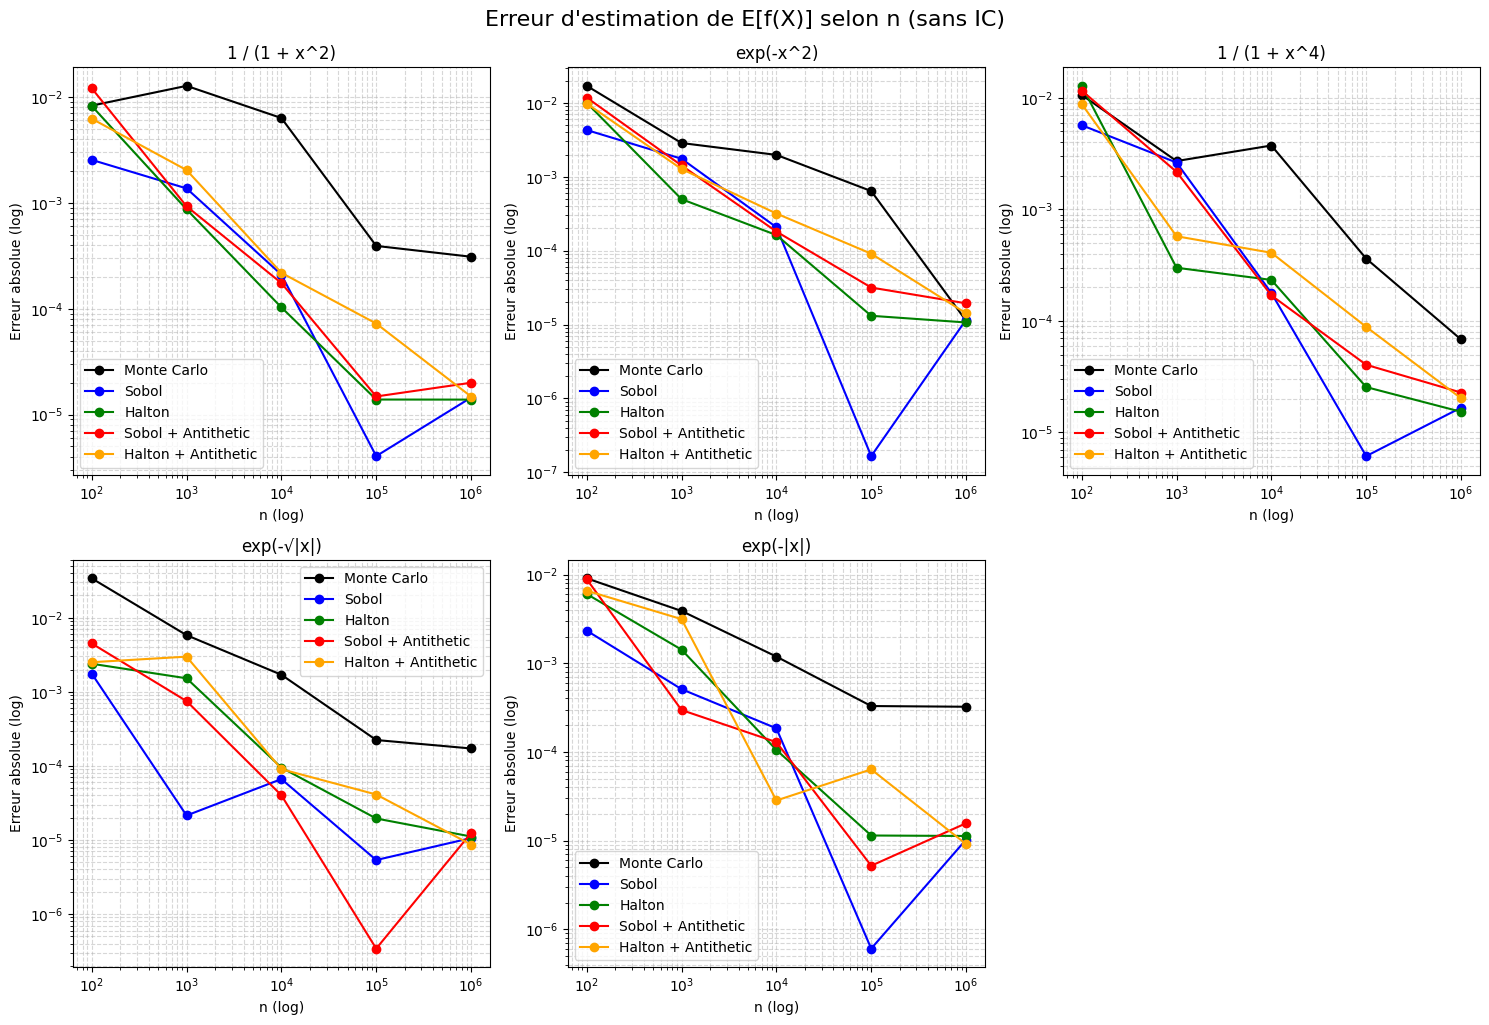

In [23]:
import matplotlib.pyplot as plt

methods = ["Monte Carlo", "Sobol", "Halton", "Sobol + Antithetic", "Halton + Antithetic"]
colors = ["black", "blue", "green", "red", "orange"]

plt.figure(figsize=(15, 10))

for i, (function_name, mu_ref) in enumerate(zip(function_names, Limit), 1):
    plt.subplot(2, 3, i)
    for method, color in zip(methods, colors):
        errors = []
        for n in n_values:
            row = [r for r in results[f"results_{n}"] if r["Function"] == function_name][0]
            if method in row:
                estimate = float(row[method][0])
                ref = float(mu_ref[0])
                errors.append(abs(estimate - ref))
            else:
                errors.append(np.nan)
        plt.plot(n_values, errors, label=method, marker='o', color=color)

    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("n (log)")
    plt.ylabel("Erreur absolue (log)")
    plt.title(function_name)
    plt.grid(True, which="both", linestyle="--", alpha=0.5)
    plt.legend()

plt.tight_layout()
plt.suptitle("Erreur d'estimation de E[f(X)] selon n (sans IC)", fontsize=16, y=1.02)
plt.show()

Our results show that Random-Quasi-Monte Carlo methods, particularly Sobol and Halton sequences, significantly outperform classical Monte Carlo in estimating expectations under heavy-tailed alpha-stable distributions. Across all test functions, RQMC methods consistently achieve lower errors and faster convergence rates, even for small sample sizes. Interestingly, the use of antithetic variates does not bring additional improvement in this context. This may be due to the already highly uniform coverage provided by RQMC sequences, especially for symmetric and smooth functions. In some cases, the antithetic extension may even slightly increase variance, particularly when dealing with heavy-tailed distributions.

# Rajouter les intervalles de confiances

## **III. Question 3 : ABC methods**

According to what we found earlier, we are going to continue with the Sobol sequence. The amount of n_value that we will use is usually $ n_{value} = 10 000 $. And it seems that for this value, Sobol is the best generator.